# Dense Neural Network and embedding for NLP

In this exercise, I explore the use of Dense Neural Network applied to NLP.
The goal is to provide an example of NLP classification in the form of sentiment
analysis using tensorflow. The general workflow is the same as in the previous exercise but with the addition of embedding. We will look into:

- preprocessing
- vectorization
- embedding
- feature extraction and classification using DNN

## Preprocessing

Text often contains unecessary information or things we want to mofidy.  A common preprocessing setps is to remove punctuation and lower casing. Removing stop words is another common steps. Stop words are wors that are not useful in the process of classification (the or is for instance in English).
The preprocess stepts vary and can be  define before the text vectorization or as part of the vectorization. If it is done as part of the vectorization, we can pass a function or set specific parameters.

## Vectorization

Before using any ML method, we must first convert the text into numerical values. This is the process of tokenization or vectorization. We can choose different levels for the tokens of the text: characters, words or sentences. In this exercise, we will use word tokenization and will explore sentence tokenization later.

The output of this step is typically tensor/matrix with document in the row and tokens as columns. There are multiple variation of the matrix (count, frequency, tfidf). In the case of one hot encoding vectorization, the matrix shows the presence of a token for a document. In the case of the frequency count vectorization matrix, it shows the frequency of each words in a document. In most cases, the matrix/tensor is usually sparse and is processed to reduce its dimension.

## Embedding

Embedding provides a way to represent text using continuous vector values. It can represent tokens relationship or semantic relations in more efficient way. Vectorization can produce very large sparse and embedding provides more useful ways to represent words in reduced size space. Example of typical embedding include Wordtovect and GLOVE. These embeddings were created on very large text dataset and often called pre-trained embedding space. In this exercise, we create our own embedding layer in the deep learning model using the text corpus we have.

The text vectorization and embedding steps are sometimes called encoding.

## Dense Neural Network: features and classification

Embedding layers will feed into intermediary layers that will create features of relevance to the classification. This usually called the feature extractor (backbone) of the DL neural network. The top or head of the network contains the classifier: the neural network corresponding to a binary or multiple category classification.

## Dataset

In this exercise, we use the Twitter US airline sentiment dataset. It is a public dataset published used in the Kaggle competition published in 2015. It contains about 16k reviews classified into three sentiment categories: negative, neutral and positive.

Useful links:

- twitter sentiment airlines data:

https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment


# Set up environment and load libraries

- load libraries
- install packages and tools
- authenticate to google drive and gcp account

In [1]:
!pip uninstall tensorflow -y
!pip install  tensorflow==2.13 #specific version needed for BERT

Found existing installation: tensorflow 2.13.0
Uninstalling tensorflow-2.13.0:
  Successfully uninstalled tensorflow-2.13.0
  Using cached tensorflow-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (524.1 MB)


In [2]:
!pip install np_utils

In [3]:
###### Library used in this script
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os, glob

#ML imports
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


#Keras import
from tensorflow import keras
#from keras.models import Model
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Concatenate, Activation, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model


#from keras.utils import np_utils
import np_utils
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('display.max_columns', 50)

#Please download the below also. This will resolve your issue:

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

#nltk.download('omw-1.4'*)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
#GCP account authentification
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [6]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Functions
In the next part of the script, we declare all the functions used in the sripts.  It is good practice to place functions at the beginning of a script or in an external source file. Here are the 13 functions used:

* **create_dir_and_check_existence**:  create and output directory given a path. The output directory will be the working directory throughout the analysis.


In [7]:
def create_dir_and_check_existence(path):

    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")

from matplotlib import pyplot

In [8]:
def clean_text(data):

    import re

    #1. Removing URLS
    data = re.sub('http\S+', '', data).strip()
    data = re.sub('www\S+', '', data).strip()

    #2. Removing Tags
    data = re.sub('#\S+', '', data).strip()

    #3. Removing Mentions
    data = re.sub('@\S+', '', data).strip()

    #4. Removing upper brackets to keep negative auxiliary verbs in text
    data = data.replace("'", "")

    #5. Tokenize
    text_tokens = word_tokenize(data.lower())

    #6. Remove Puncs and number
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]

    #7. Removing Stopwords
    stop_words = stopwords.words('english')
    for i in ["not", "no"]:
            stop_words.remove(i)
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #8. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]


    #joining
    return " ".join(text_cleaned)

In [9]:
#pulled from tensorflow tutorial and more
#https://stackoverflow.com/questions/70854665/tensorflow-textvectorization-convert-the-predicted-text-back-to-a-human-readabl

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<\b>' ,' ')
  return tf.strings.regex_replace(stripped_html,'[%s#@]' % re.escape(string.punctuation),'')

def normalize(text):
  remove_regex = f'[{re.escape(string.punctuation)}]'
  space_regex = '...'
  result = tf.strings.lower(text)
  result = tf.strings.regex_replace(result, remove_regex, '')
  result = tf.strings.regex_replace(result, space_regex, ' ')
  return result

In [10]:
def generate_accuracy(model,y_test,x_test,class_names=None):

  """
  Function to predict and generate accuracy metrics (precision and recall) for each model given input x and y test.

  Extended description of function.

  Parameters:
  model: keras model
  y_test: Input target for test
  y_train: target train labels used in classification
  class_names: labels for the class predicted

  Returns:
  report_df: pandas data frame with accuracy metrics

  """

  # we can store the array in a data.frame and get the max
  y_score = model.predict(x_test)
  y_score.shape
  y_pred_test_df = pd.DataFrame(y_score)
  y_pred_test_df['y_pred_test'] = y_pred_test_df.idxmax(axis = 1) #one to go across the column for each row
  y_pred_test_df


  y_pred_test = y_pred_test_df['y_pred_test']
  report_dict=classification_report(y_test,
                                      y_pred_test,
                                      target_names=class_names,
                                      output_dict=True)
  report_df = pd.DataFrame(report_dict)
  #confusion_matrix_val = confusion_matrix(y_test,y_pred_test)  #not in use here
  model_name = model._name
  #display(report_df)
  report_df = (report_df.drop(columns=['macro avg','weighted avg'])
                        .drop(labels=['f1-score','support'])
                        .assign(model_name= lambda x: model_name)
                        .assign(num_param= lambda x: model.count_params())
                        .reset_index()
                        .rename(columns={'index':'metric'})
              )

  return report_df

# Parameters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).


In [11]:
############################################################################
#####  Parameters and argument set up ###########

#ARG 1
in_dir = '/content/gdrive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/DNN_and_embedding_nlp/data'
out_dir = '/content/gdrive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/DNN_and_embedding_nlp/'

in_filename = 'Tweets.csv'
out_suffix = 'DNN_embedding_nlp_2024-01-29'
test_proportion = 0.2
random_seed= 42
create_out_dir = True

#ARG 7
## Input data
data_dir = '/content/drive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/DNN_embedding_nlp/data/'
#ARG 8
run_model = True #if True, model is trained, note this may take several hours.

#ARG 9
# Use pre-trained model if run_model is False
model_path = None
#model_path ='/content/drive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/DNN_embedding_nlp/'
#ARG 10
epoch_val = 100
#ARG 11


In [12]:
################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,"outputs",out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(out_dir) #use working dir defined earlier


directory already exists


In [13]:
print(out_dir)

/content/gdrive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/DNN_and_embedding_nlp/outputs/output_data_DNN_embedding_nlp_2024-01-29


In [14]:
!pwd

/content/gdrive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/DNN_and_embedding_nlp/outputs/output_data_DNN_embedding_nlp_2024-01-29


#0.Workflow/pipeline

We describe here the modeling pipelin we set up for this exercise:
1. **Load and explore data**
- Obtain data from the website or link provided
- Quick exploration
2. **Intro to Textvectorization and Embedding: tensorflow**
- defining layers
- hyper parameters
3. **Train test split**
- create test test split
4. **Build and train models**
- set up baseline model (random forest)
- build DNN model
5. **Visualize and Explore fitted embedding**
- dimension reduction
- visualization
6. **Accuracy Assessment**
- AUC ROC and precision recall curves
- precisions recal metrics
- IOU metric
7. **Conclusions**


# 1.Load and explore data

We used the airlines review sentiment data tweets from Kaggle. There are 14,640 tweets labeled with three sentiment categories:

- negative
- neutral
- positive

There were 15 columns including airline name and confidence in the label. Here are the most relevant columns for the modeling:

- text: column: contains the tweet text
- airline_sentiment: contains the labeled sentiment categories.

In [15]:
# Check for GPU
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-0201a118-4fa1-5341-e32b-104e690b6597)


In [16]:
import tensorflow as tf
print(tf.__version__) #should use higher tensorflow!!!

2.13.0


In [17]:
df = pd.read_csv(os.path.join(in_dir,in_filename))
print(df.shape)
print(df.columns)
df

(14640, 15)
Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different flight to Chicago.,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to #BlackBerry10,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [18]:
print(df['text'].head())

0                                                                                               @VirginAmerica What @dhepburn said.
1                                                          @VirginAmerica plus you've added commercials to the experience... tacky.
2                                                           @VirginAmerica I didn't today... Must mean I need to take another trip!
3    @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4                                                                           @VirginAmerica and it's a really big bad thing about it
Name: text, dtype: object


In [19]:
print(df['airline_sentiment'].value_counts())
print(df['airline_sentiment'].value_counts(normalize=True))


negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64
negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64


The dataset is clearly unbalanced with a majority of tweets being negative (close to 63%).

#2. **Intro to Textvectorization and Embedding: tensorflow**

We will first explore the textvectorization and embedding layers provided in tensorflow keras using a mock up dataset (see corpus below).

We'll take a look at:

- defining layers: instantiate layers for exploration and fit

- hyper parameters: parameters that can be set when using the layers.

In [20]:
corpus = [
'Food service was slow and the food was bad and late.',
'@airlineZ The flight was very delayed.',
'#airlineZ Food was cold and very late.',
'I asked for water and coffee but it never came'
]

The mock up dataset consists in 4 sentences with a variety of length with some unusual characters (# and @).

## 2.1 Textvectorization

Let's use the default parameter values first to explore the vectorization layer. Here is a short description of the main parameters:

- max_tokens: maximum number of token to consider for the modeling. It will take most frequen tokens up to the maximum number.
- standardize: preprocessing for the input text, this can be a specific option ('lower', 'lower_and_strip_punctuation') or custom function.


Intersesting links:
- https://jonathan-hui.medium.com/tensorflow-keras-preprocessing-layers-dataset-performance-considera-e9fc11de7bc7: good overview of textvectorization layer

- https://discuss.tensorflow.org/t/nlp-textvectorization-tokenizer/12505/3

In [21]:
#import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=None,
                              standardize="lower_and_strip_punctuation",
                              split="whitespace",
                              ngrams=None,
                              output_mode="int",
                              output_sequence_length=None,
                              pad_to_max_tokens=False,
                              #vocabulary=corpus,
                              idf_weights=None)
print(vectorizer)

In [22]:
vectorizer.adapt(corpus) #fit corpus data
#https://towardsdatascience.com/you-should-try-the-new-tensorflows-textvectorization-layer-a80b3c6b00ee5
print(vectorizer(corpus)) # you can see the padding here..

#a good ref:
#https://jonathan-hui.medium.com/tensorflow-keras-preprocessing-layers-dataset-performance-considera-e9fc11de7bc7
#Note:
#int 0: is used for padding i.e. " "
#int 1: is used for OOV i.e. 'UNK'
#int 2: is the first digit used for the most frequent token (in this case 'was')
#int 3: is the next digit used for the next most frequent token (in this case'and')

tf.Tensor(
[[ 4 11  2 10  3  6  4  2 22  3  7]
 [ 8  6 16  2  5 17  0  0  0  0  0]
 [ 8  4  2 18  3  5  7  0  0  0  0]
 [14 23 15  9  3 19 21 13 12 20  0]], shape=(4, 11), dtype=int64)


In [23]:
# Create sample sentence and tokenize it
sample_sentence = "Food was bad"
vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[ 4,  2, 22]])>

In [24]:
#prints count of unique values
vocab_unprocessed = set((' '.join(corpus)).split(" "))
print("Count- ", len(vocab_unprocessed))
vectorizer.vocabulary_size() #there are 23 unique words

Count-  25


24

In [25]:
vocab = vectorizer.get_vocabulary()
vocab2 = vectorizer.get_vocabulary(include_special_tokens=False)
print(vocab[:10])
print(vocab2[:10])
print(vocab[-10:])
print(vocab2[-10:])

['', '[UNK]', 'was', 'and', 'food', 'very', 'the', 'late', 'airlinez', 'water']
['was', 'and', 'food', 'very', 'the', 'late', 'airlinez', 'water', 'slow', 'service']
['i', 'for', 'flight', 'delayed', 'cold', 'coffee', 'came', 'but', 'bad', 'asked']
['i', 'for', 'flight', 'delayed', 'cold', 'coffee', 'came', 'but', 'bad', 'asked']


In [26]:
vocab, vocab_unprocessed

(['',
  '[UNK]',
  'was',
  'and',
  'food',
  'very',
  'the',
  'late',
  'airlinez',
  'water',
  'slow',
  'service',
  'never',
  'it',
  'i',
  'for',
  'flight',
  'delayed',
  'cold',
  'coffee',
  'came',
  'but',
  'bad',
  'asked'],
 {'#airlineZ',
  '@airlineZ',
  'Food',
  'I',
  'The',
  'and',
  'asked',
  'bad',
  'but',
  'came',
  'coffee',
  'cold',
  'delayed.',
  'flight',
  'food',
  'for',
  'it',
  'late.',
  'never',
  'service',
  'slow',
  'the',
  'very',
  'was',
  'water'})

In the top 10, we have 'was' which appears twice in the corpus. Note that the tokens '' and 'UNK' are also present in the top. This is because the textvectorization layer will put padding '' and the OOV 'UNK' in the list. This implies that these are the most frequent but in fact '' are always put at the top of the list by default. To remove them you can

https://github.com/keras-team/keras/blob/v2.13.1/keras/layers/preprocessing/index_lookup.py#L370

https://stackoverflow.com/questions/68440502/why-is-unk-word-the-first-in-word2vec-vocabulary


TALK ABOUT padding (or mask) and OOV: out of vocabulary

In [27]:
set((' '.join(corpus)).split(" ")) #note that @ was removed

{'#airlineZ',
 '@airlineZ',
 'Food',
 'I',
 'The',
 'and',
 'asked',
 'bad',
 'but',
 'came',
 'coffee',
 'cold',
 'delayed.',
 'flight',
 'food',
 'for',
 'it',
 'late.',
 'never',
 'service',
 'slow',
 'the',
 'very',
 'was',
 'water'}

In [28]:
# Get the unique words in the vocabulary
words_in_vocab = vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 24
Top 5 most common words: ['', '[UNK]', 'was', 'and', 'food']
Bottom 5 least common words: ['coffee', 'came', 'but', 'bad', 'asked']


In [29]:
vectorizer.name
vectorizer.get_config()
#if output sequence length is None it will be set to the length of the longest sequence in the input text. This may mean a lot of padding.

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': None,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': None,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 24}

In [30]:
[len(sentence.split(" ")) for sentence in corpus] #this means the output_sequence_length will be set to 11

[11, 6, 7, 10]

In [31]:
# Create sample sentence and tokenize it
sample_sentence = corpus[2]
vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 7), dtype=int64, numpy=array([[ 8,  4,  2, 18,  3,  5,  7]])>

## 2.2 Embedding

There are two required input parameters:
- input_dim : size of the vocabulary (number of unique tokens)
- output_dim: size of the output embedding space

The other arguments have default values. Some important one to know about:
- embeddings_initializer: set to uniform by default

Useful links to consider:

- https://www.tensorflow.org/text/guide/word_embeddings
- https://www.tensorflow.org/tutorials/keras/text_classification_with_hub: use pre-trained word embedding
- classify text/sentiment with BERT: https://www.tensorflow.org/text/tutorials/classify_text_with_bert
- https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671
- pytorch bert fine tuning: https://medium.com/@Mirza_Yusuf/using-a-bert-model-for-sentiment-analysis-6c6fcc106843


In [32]:
vocab_size = 24
embedding_size = 8
embedding = tf.keras.layers.Embedding(
               input_dim=vocab_size ,
              output_dim=embedding_size,
    embeddings_initializer='uniform'
)

In [33]:
print(embedding(tf.constant([10,4,5,9])).shape)
print(embedding(tf.constant([10,4,5,9])))
#embeding takes input integer values

(4, 8)
tf.Tensor(
[[-0.04203214  0.01337994  0.03646312  0.04929337 -0.02708019  0.03615806
  -0.02131817  0.03544432]
 [ 0.0381338   0.02051058 -0.00297564  0.00727659 -0.0020958   0.02214464
   0.04702822  0.03563849]
 [-0.01176278 -0.03545793 -0.04711372 -0.0077669   0.02898845  0.02509258
   0.00513568  0.00782961]
 [ 0.00749301  0.0486594  -0.02077652 -0.02625374  0.03160615  0.01160811
   0.01325678  0.02337328]], shape=(4, 8), dtype=float32)


Now let's pass the corpus:

In [34]:
x = embedding(vectorizer(corpus))
print(x.shape)
print(x[0].shape)
print(x[0])
print(corpus[0]) #11 tokens (words) with 8 dimensional embedding space

(4, 11, 8)
(11, 8)
tf.Tensor(
[[ 0.0381338   0.02051058 -0.00297564  0.00727659 -0.0020958   0.02214464
   0.04702822  0.03563849]
 [-0.01234647  0.00941389 -0.01064409  0.02751068  0.01814169  0.04831708
  -0.01712921  0.01455048]
 [-0.02727546  0.04718148 -0.03252397  0.01089138  0.00344657 -0.0218935
  -0.01862286  0.04076533]
 [-0.04203214  0.01337994  0.03646312  0.04929337 -0.02708019  0.03615806
  -0.02131817  0.03544432]
 [-0.01591966 -0.03781153 -0.04928296  0.04846514  0.02763529 -0.02552445
  -0.01914325  0.04301698]
 [ 0.04362161 -0.03769841  0.02246776  0.04962229  0.01511805 -0.03334907
   0.02947109 -0.00124961]
 [ 0.0381338   0.02051058 -0.00297564  0.00727659 -0.0020958   0.02214464
   0.04702822  0.03563849]
 [-0.02727546  0.04718148 -0.03252397  0.01089138  0.00344657 -0.0218935
  -0.01862286  0.04076533]
 [-0.03393525  0.00967889  0.04325919 -0.04072176 -0.00050389  0.04192467
   0.03544815  0.00283583]
 [-0.01591966 -0.03781153 -0.04928296  0.04846514  0.02763529 -

#3. **Train test split and fitting text vectorizer and embedding**

Next, we split the airlines tweet data into training and testing. We will also fit the text vectorizer to the training set and create the embedding layer.

## 3.1 Generate train test split

In [35]:
cleaned_txt = df["text"].apply(clean_text) #need to fix this step
df["text_cleaned"] = cleaned_txt
df["text_cleaned"].head()



0                                                                              said
1                                      plus youve added commercial experience tacky
2                                      didnt today must mean need take another trip
3    really aggressive blast obnoxious entertainment guest face amp little recourse
4                                                              really big bad thing
Name: text_cleaned, dtype: object

In [36]:
del cleaned_txt
from sklearn.model_selection import train_test_split
#X = df['text_cleaned']
X = df['text_cleaned']
df["target"] = df["airline_sentiment"].map({"positive": 2, "neutral": 1, "negative": 0}) #we need to recode the string to int

y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [37]:
df.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
text_cleaned                     object
target                            int64
dtype: object

In [38]:
df['airline_sentiment'].value_counts(dropna=False)

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [39]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11712,)
(2928,)
(11712,)
(2928,)


In [40]:
X_train

1262                                                                                           would cost
10772                              used get email snack time check got neither tomorrow trip not get sent
4204     no flight cancelled flightlations one due weather one mechanical paid hotel bag held transfer no
5491                                                                not frustrated idea great crew thanks
12096                                                                 narrowly made standby lot snag trip
                                                       ...                                               
305                          flight booking problem section website seems broken chrome might wan na look
10579                      thanks hour flight pit phx zero entertainment guess quarter million mile delta
4514                        assigned seating cousin amp probably cant sit together flight tomorrow thanks
7131                                          

## 3.2 Fit text vectorizer on training samples

In [41]:

#import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

#max_tokens = 15000
vectorizer = TextVectorization(max_tokens=None,
                              standardize="lower_and_strip_punctuation",
                              split="whitespace",
                              ngrams=None,
                              output_mode="int",
                              output_sequence_length=None,
                              pad_to_max_tokens=False,
                              #vocabulary=corpus,
                              idf_weights=None)
print(vectorizer)

In [42]:
# Fit the text vectorizer to the training text
vectorizer.adapt(X_train)

In [43]:
# Get the unique words in the vocabulary
words_in_vocab = vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 7777
Top 5 most common words: ['', '[UNK]', 'flight', 'not', 'no']
Bottom 5 least common words: ['ab', 'aaron', 'aal', 'aadavantage', 'aaaand']


In [44]:
print(np.mean([len(x_val) for x_val in X_train]))
print(np.median([len(x_val) for x_val in X_train]))
print(np.max([len(x_val) for x_val in X_train]))
print(np.min([len(x_val) for x_val in X_train]))

53.98753415300546
57.0
129
0


In [45]:
#import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

max_vocab = 5000
sequence_length = 60
vectorizer = TextVectorization(max_tokens=max_vocab,
                              standardize="lower_and_strip_punctuation",
                              split="whitespace",
                              ngrams=None,
                              output_mode="int",
                              output_sequence_length=sequence_length,
                              pad_to_max_tokens=False,
                              idf_weights=None)
print(vectorizer)

In [46]:
# Fit the text vectorizer to the training text
vectorizer.adapt(X_train)
# Get the unique words in the vocabulary
words_in_vocab = vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 5000
Top 5 most common words: ['', '[UNK]', 'flight', 'not', 'no']
Bottom 5 least common words: ['skyw', 'skycap', 'skipper', 'skip', 'skillful']


#4. **Build and train model**
- set up baseline model (random forest)
- build DNN model

Let's define model 1 which is a simple fully connected neural network using the dense keras tensorflow layer.

In [47]:
#base line mode?

# 4.1 Dense model

In [48]:
vocab_size = max_vocab
embedding_size = 16
num_classes = 3

In [49]:

inputs = layers.Input(shape=(1,), dtype="string")
x = vectorizer(inputs)
x = layers.Embedding(input_dim = vocab_size,
                     output_dim = embedding_size,
                     name = "embedding1")(x)
x = layers.Dense(8,activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer, want binary outputs so use sigmoid activation
model_dnn = tf.keras.Model(inputs, outputs, name= "dnn_model") # construct the model

'''
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
'''

model_dnn._name = 'model_dnn' # set keras model name

## Compile model
model_dnn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [50]:
model_dnn.summary()

Model: "model_dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 60)                0         
 Vectorization)                                                  
                                                                 
 embedding1 (Embedding)      (None, 60, 16)            80000     
                                                                 
 dense (Dense)               (None, 60, 8)             136       
                                                                 
 global_average_pooling1d (  (None, 8)                 0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_1 (Dense)             (None, 3)                 27

In [51]:
# Fit model: takes between 50 and 60 minutes for epoch 10, about 10-12 minutes for 2 epochs

batch_size = 128
epochs = 2
# Fit the model
#https://stackoverflow.com/questions/40186722/cast-string-to-float-is-not-supported-in-linear-model
model_dnn_history = model_dnn.fit(X_train, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              y_train,
                              batch_size=batch_size,
                              epochs=epochs)#,
                              #validation_data=(val_sentences, val_labels),
                              #callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                              #                                       experiment_name="simple_dense_model")])


Epoch 1/2
92/92 [==============================] - 1s 3ms/step - loss: 1.0096 - accuracy: 0.6158
Epoch 2/2
92/92 [==============================] - 0s 3ms/step - loss: 0.9181 - accuracy: 0.6270


## 4.2 Recurrent LSTM model

In [52]:
vocab_size = max_vocab
embedding_size = 16
num_classes = 3

In [53]:
inputs = layers.Input(shape=(1,), dtype="string")
x = vectorizer(inputs)
x = layers.Embedding(input_dim = vocab_size,
                     output_dim = embedding_size,
                     name = "embedding2")(x)
                     # x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
#x = layers.LSTM(64)(x) # return vector for whole sequence

x = layers.LSTM(8,return_sequences=True)(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer, want binary outputs so use sigmoid activation
model_lstm = tf.keras.Model(inputs, outputs, name= "lstm_model") # construct the model

model_lstm._name = 'model_lstm' # set keras model name

## Compile model
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [54]:
model_lstm.summary()

Model: "model_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 60)                0         
 Vectorization)                                                  
                                                                 
 embedding2 (Embedding)      (None, 60, 16)            80000     
                                                                 
 lstm (LSTM)                 (None, 60, 8)             800       
                                                                 
 global_average_pooling1d_1  (None, 8)                 0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 3)                 2

In [55]:
# Fit model
batch_size =128
epochs = 2
# Fit model: takes between 50 and 60 minutes for epoch 10, about 10-12 minutes for 2 epochs

lstm_history = model_lstm.fit(X_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_split = 0.2,
                shuffle=True)

Epoch 1/2
74/74 [==============================] - 4s 31ms/step - loss: 0.9837 - accuracy: 0.6178 - val_loss: 0.9162 - val_accuracy: 0.6236
Epoch 2/2
74/74 [==============================] - 2s 22ms/step - loss: 0.9011 - accuracy: 0.6278 - val_loss: 0.8920 - val_accuracy: 0.6236


## 4.3 CNN model

In [56]:

inputs = layers.Input(shape=(1,), dtype="string")
x = vectorizer(inputs)
x = layers.Embedding(input_dim = vocab_size,
                     output_dim = embedding_size,
                     name = "embedding3")(x)
x = layers.Conv1D(16,kernel_size=5,activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer, want binary outputs so use sigmoid activation
model_cnn = tf.keras.Model(inputs, outputs, name= "model_cnn") # construct the model

model_cnn._name = 'model_cnn' # set keras model name

## Compile model
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [57]:
model_cnn.summary()

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 60)                0         
 Vectorization)                                                  
                                                                 
 embedding3 (Embedding)      (None, 60, 16)            80000     
                                                                 
 conv1d (Conv1D)             (None, 56, 16)            1296      
                                                                 
 global_average_pooling1d_2  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (None, 3)                 51

In [58]:
# Fit model
batch_size =128
epochs = 2
# Fit model: takes between 50 and 60 minutes for epoch 10, about 10-12 minutes for 2 epochs

cnn_history = model_cnn.fit(X_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_split = 0.2,
                shuffle=True)

Epoch 1/2
74/74 [==============================] - 1s 7ms/step - loss: 0.9848 - accuracy: 0.6278 - val_loss: 0.9221 - val_accuracy: 0.6236
Epoch 2/2
74/74 [==============================] - 0s 4ms/step - loss: 0.9094 - accuracy: 0.6278 - val_loss: 0.9053 - val_accuracy: 0.6236


## 4.4 Training models created

In [59]:
## Loop through this
#run_model = True
list_models=[model_dnn,model_lstm,model_cnn] #use the model

list_hist_df=[]
epochs = 100
batch_size = 128

if run_model==True:

  for model in list_models:
  #if run_model=True then train model and store weights and history

    # Fit model: takes between 50 and 60 minutes

    model_name = model._name
    history_model = model.fit(X_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_split = 0.2,
                shuffle=True)

    hist_df = pd.DataFrame(history_model.history)

    # save to json:
    hist_json_file = 'history_'+model_name+'_'+out_suffix+'.json'
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)
    # save to csv:
    hist_csv_file = 'history_'+model_name+'_'+out_suffix+'.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    # serialize weights to HDF5
    #model.save_weights(model_name+'_'+out_suffix+'.h5')
    #model.save_weights(model_name+'_'+out_suffix+'.h5')
    #Passing save_format='tf' to save()
    #model.save(model_name+'_'+out_suffix+'.keras')
    model.save(model_name+'_'+out_suffix,save_format='tf')
    list_hist_df.append(hist_df)
    print("Saved model to disk ", model_name)

  #if run_model=False then load models weights and loss history from h5 file
if run_model==False:
  if model_path is None:
    model_path = out_dir #classified
    print('Set model path to output directory')

  model_names=['model_dnn','model_lstm','model_cnn']
  i=0
  for model_name in model_names:
    print(i)
    print(model_name)
    fileglob ="*"+model_name+"*.h5"
    model_path_filename= os.path.join(model_path,fileglob) #classified
    model_path_filename = glob.glob(model_path_filename,recursive=False)[0]
    model=list_models[i]
    model.summary()
    print('This is the model path ',model_path_filename)
    model.load_weights(model_path_filename)
    fileglob ='*'+model_name+"*.csv"
    history_model_path = os.path.join(model_path,fileglob) #classified
    history_model_path = glob.glob(history_model_path,recursive=False)[0]
    hist_df = pd.read_csv(history_model_path)
    list_models[i]=model #put the updated model with weights in the list
    list_hist_df.append(hist_df)
    i=i+1

#https://www.tensorflow.org/tutorials/keras/save_and_load

Epoch 1/100
74/74 [==============================] - 0s 6ms/step - loss: 0.9019 - accuracy: 0.6278 - val_loss: 0.8992 - val_accuracy: 0.6236
Epoch 2/100
74/74 [==============================] - 0s 3ms/step - loss: 0.8842 - accuracy: 0.6278 - val_loss: 0.8773 - val_accuracy: 0.6236
Epoch 3/100
74/74 [==============================] - 0s 4ms/step - loss: 0.8531 - accuracy: 0.6278 - val_loss: 0.8393 - val_accuracy: 0.6236
Epoch 4/100
74/74 [==============================] - 0s 4ms/step - loss: 0.8037 - accuracy: 0.6282 - val_loss: 0.7859 - val_accuracy: 0.6248
Epoch 5/100
74/74 [==============================] - 0s 4ms/step - loss: 0.7431 - accuracy: 0.6404 - val_loss: 0.7306 - val_accuracy: 0.6551
Epoch 6/100
74/74 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.6963 - val_loss: 0.6886 - val_accuracy: 0.6965
Epoch 7/100
74/74 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.7385 - val_loss: 0.6550 - val_accuracy: 0.7405
Epoch 8/100
7

In [60]:
print(list_models)


[<keras.src.engine.functional.Functional object at 0x7f19947f1630>, <keras.src.engine.functional.Functional object at 0x7f18c3c5e5f0>, <keras.src.engine.functional.Functional object at 0x7f18c0293cd0>]


In [61]:
model_path

In [62]:
#history_model_path
list_hist_df

[        loss  accuracy  val_loss  val_accuracy
 0   0.901903  0.627815  0.899212      0.623560
 1   0.884173  0.627815  0.877265      0.623560
 2   0.853061  0.627815  0.839309      0.623560
 3   0.803750  0.628242  0.785938      0.624840
 4   0.743136  0.640410  0.730626      0.655143
 ..       ...       ...       ...           ...
 95  0.152495  0.948981  1.076665      0.750320
 96  0.151063  0.949728  1.087653      0.750320
 97  0.149517  0.950475  1.098063      0.749466
 98  0.148245  0.950795  1.107402      0.749893
 99  0.146857  0.951649  1.117996      0.748186
 
 [100 rows x 4 columns],
         loss  accuracy  val_loss  val_accuracy
 0   0.786581  0.652257  0.692030      0.709347
 1   0.626681  0.734337  0.654974      0.760563
 2   0.543856  0.788985  0.594837      0.768673
 3   0.469942  0.832640  0.594525      0.769526
 4   0.416809  0.860284  0.582242      0.785745
 ..       ...       ...       ...           ...
 95  0.121484  0.972356  1.084603      0.738796
 96  0.131996

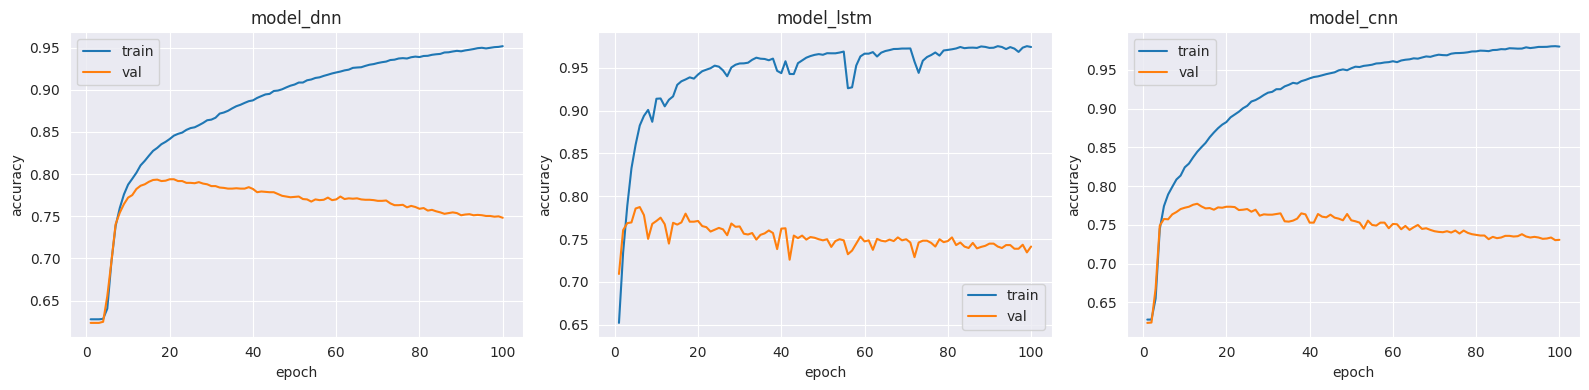

In [63]:
num_models=3
fig, ax = plt.subplots(1,num_models,figsize=(16,4))
model_names=['model_dnn','model_lstm','model_cnn']

for model_val in range(num_models):
  hist_df=list_hist_df[model_val]
  hist_df['epoch']=np.arange(1,hist_df.shape[0]+1)
  ax[model_val].plot(hist_df['epoch'],hist_df['accuracy'],label='train')
  ax[model_val].plot(hist_df['epoch'],hist_df['val_accuracy'],label='val')
  ax[model_val].set_title(model_names[model_val])
  ax[model_val].set_xlabel('epoch')
  ax[model_val].set_ylabel('accuracy')
  ax[model_val].legend()

fig.tight_layout()

# 4.5 Adding model checkpoints and callback

It is clear from the previous step that we may be overfitting the models and we should probably introduce call back to avoid some of these related issues.

# 5. Visualize and explore trained embedding

#6. Accuracy Assessement and evaluation of models

In [64]:
#model_use.predict(X_test)
y_score = model_cnn.predict(X_test)
print(type(y_score))
y_score.shape

92/92 [==============================] - 0s 2ms/step
<class 'numpy.ndarray'>


(2928, 3)

In [65]:
y_pred_test_df = pd.DataFrame(y_score)
y_pred_test_df['y_pred_test'] = y_pred_test_df.idxmax(axis = 1) #one to go across the column for each row

y_pred_test_df

,0,1,2,y_pred_test
0,0.326705,6.472442e-01,2.605093e-02,1
1,0.526364,3.358564e-01,1.377799e-01,0
2,1.000000,1.806550e-31,6.028875e-34,0
3,0.999999,1.115114e-06,2.386282e-11,0
4,1.000000,5.925864e-17,1.120632e-21,0
...,...,...,...,...
2923,0.998875,1.122426e-03,2.889717e-06,0
2924,0.000005,2.101818e-02,9.789764e-01,2
2925,1.000000,4.226941e-07,9.217112e-14,0
2926,0.002357,9.976391e-01,3.838566e-06,1


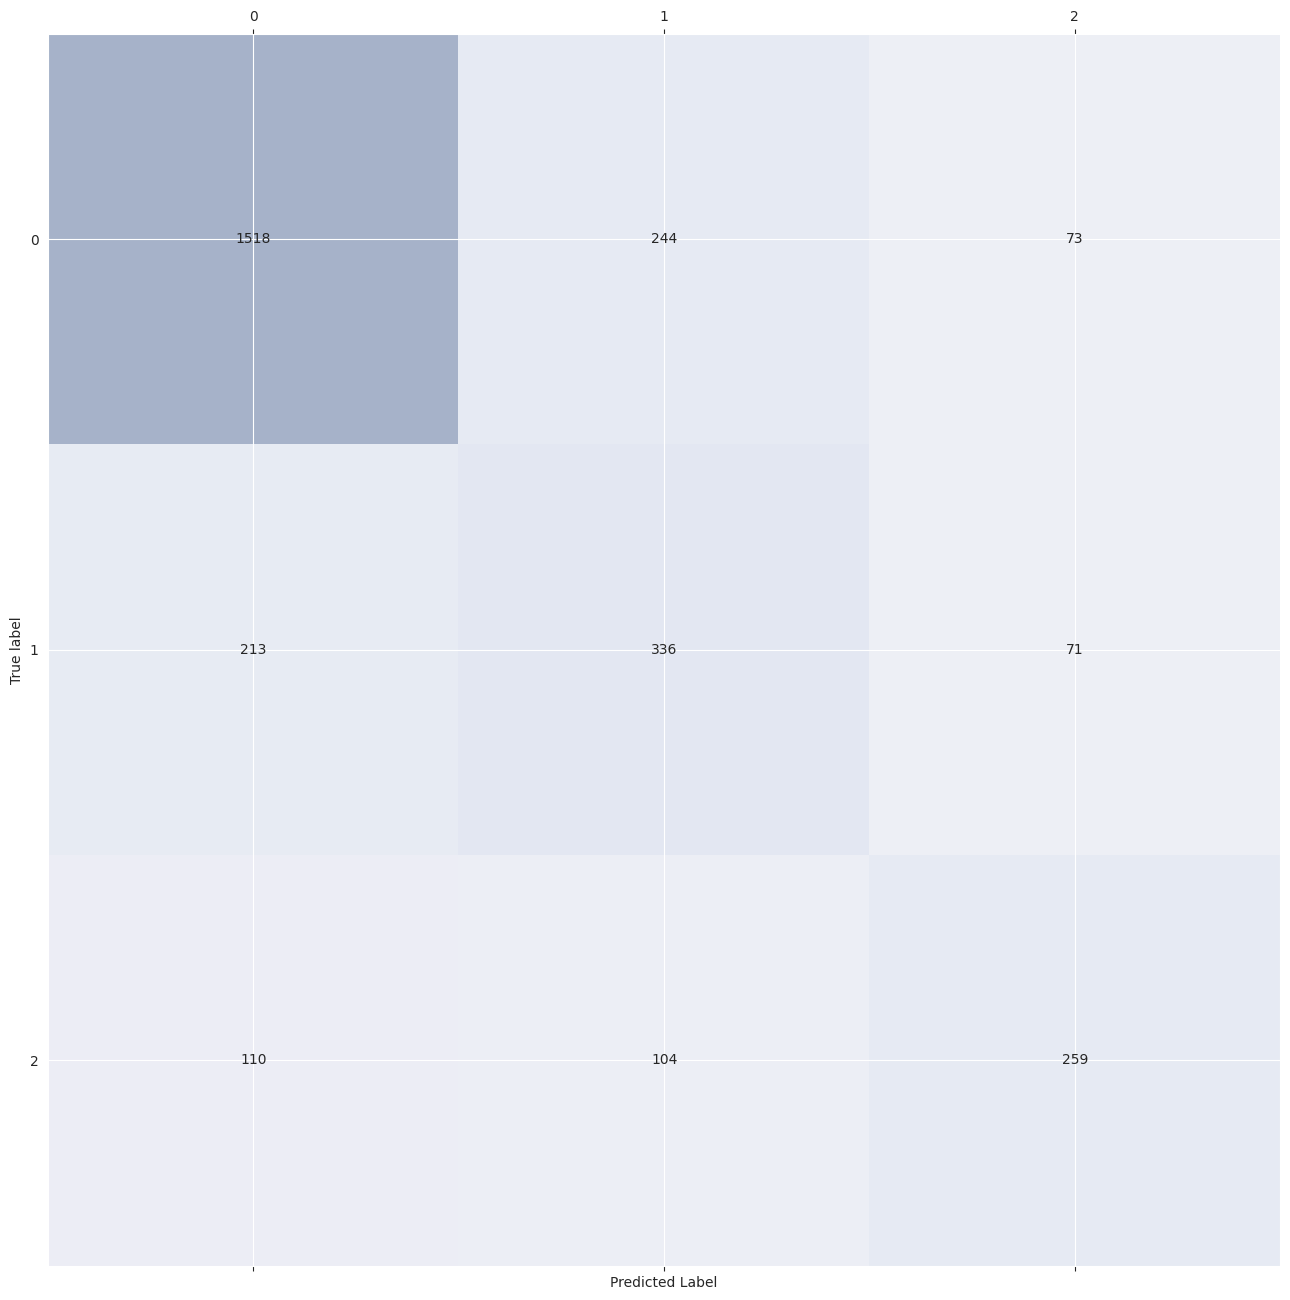

In [66]:
#from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix
y_pred_test = y_pred_test_df['y_pred_test']
report_dict=classification_report(y_test,
                                      y_pred_test,
                                      output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
confusion_matrix_val = confusion_matrix(y_test,y_pred_test)

fig, ax = plt.subplots(figsize=(16,16))
ax.matshow(confusion_matrix_val,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confusion_matrix_val.shape[0]):
  for j in range(confusion_matrix_val.shape[1]):
    ax.text(x=j,y=i,
               s=confusion_matrix_val[i,j],
               va='center',
               ha='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('True label')

In [67]:
report_df

,precision,recall,f1-score,support
0,0.824552,0.827248,0.825898,1835.000000
1,0.491228,0.541935,0.515337,620.000000
2,0.642680,0.547569,0.591324,473.000000
accuracy,0.721653,0.721653,0.721653,0.721653
macro avg,0.652820,0.638917,0.644186,2928.000000
weighted avg,0.724591,0.721653,0.722243,2928.000000


In [68]:
list_report_df = []
class_names=['negative','neutral','positive']
for model in list_models:
  report_df = generate_accuracy(model,y_test,X_test,class_names=class_names )
  list_report_df.append(report_df)
#list_report_df

from functools import reduce
report_df = reduce(lambda df1,df2: df1.merge(df2,"outer"),list_report_df)
report_df

92/92 [==============================] - 0s 2ms/step


,metric,negative,neutral,positive,accuracy,model_name,num_param
0,precision,0.837493,0.556098,0.665116,0.753074,model_dnn,80163
1,recall,0.859401,0.551613,0.604651,0.753074,model_dnn,80163
2,precision,0.836324,0.547287,0.675676,0.748292,model_lstm,80827
3,recall,0.838147,0.569355,0.634249,0.748292,model_lstm,80827
4,precision,0.824552,0.491228,0.642680,0.721653,model_cnn,81347
5,recall,0.827248,0.541935,0.547569,0.721653,model_cnn,81347


#7.Conclusions







In [69]:
############################# END OF SCRIPT ###################################